# ****============== CUSTOMER SEGMENTATION =================****

Pada notebook ini, saya akan melakukan ekslporasi data dan mencoba membuat segmentasi pelanggan pada sebuah market place di Brazil menggunakan metode RFM Analysis. Tujuan dari project ini adalah untuk membatu tim marketing dalam menentukan target marketnya agar lebih tepat sasaran. 
Notebook ini akan saya bagi menjadi beberapa tahapan sebagai berikut:

1. Konteks
2. Data Preprocessing
3. Modelling
4. Kesimpulan

Notebook ini tidak terlalu dalam membahas teorinya, namun saya akan memberikan alasan-alasan kenapa saya melakukan langkah-langkah tersebut. Mari kita mulai!

# **1. KONTEKS**

Dataset ini merupaka dari Olist, yaitu sebuah marketplace terbesar di Brazil. Data ini dikumpulkan dalam rentang waktu tahun 2016 - 2018. Olist menghubungkan usaha kecil dari seluruh Brazil untuk masuk ke dalam jaringan mereka dengan sangat mudah cukup bermodalkan kontrak. Para pengusaha tersebut dapat menjual produk mereka melalui platform Olist dan langsung dikirimkan ke customer mereka dengan kurir yang sudah bekeraja sama dengan Olist.

Setelah customer membeli produknya dari Olist, penjual akan mendapatkan pemberitahuan untuk segera memenuhi pesanan customer. Ketika customer menerima produk, customer dapat memberikan rating kepuasan dan komentar terkait pelayanan yang diberikan penjual memalui email yang dikirimakn.

Data yang dikumplan terdapat di 9 file yang berbeda, sehingga perlu digabungkan untuk mendapatkan keseluruhan data berdasarkan parameter yang kita inginkan. Di bawah ini merupakan skema keterhubungan antar datanya untuk dijadikan patokan saat melakuakn penggabungan data

![](https://i.imgur.com/HRhd2Y0.png)

In [208]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv


In [209]:
#Importing Libraries
#Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#Fetaure Selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#Modelling Algoritm
from sklearn.cluster import KMeans

#Model Evaluation
from yellowbrick.cluster import SilhouetteVisualizer

In [210]:
#Load All The Data
olist_orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
olist_products = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
olist_items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
olist_customers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
olist_payments = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
olist_sellers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv')
olist_geolocation = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv')
olist_reviews = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv')
olist_product_category_name = pd.read_csv('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv') #Untuk menerjemahkan dari bahasa Brazil ke Bahasa Inggris

In [211]:
#Menggabungkan semua data-data 
all_data = olist_orders.merge(olist_items, on='order_id', how='left')
all_data = all_data.merge(olist_payments, on='order_id', how='inner')
all_data = all_data.merge(olist_reviews, on='order_id', how='inner')
all_data = all_data.merge(olist_products, on='product_id', how='inner')
all_data = all_data.merge(olist_customers, on='customer_id', how='inner')
all_data = all_data.merge(olist_sellers, on='seller_id', how='inner')
all_data = all_data.merge(olist_product_category_name,on='product_category_name',how='inner')
#all_data = all_data.merge(olist_geolocation, on='seller_zip_code_prefix', how='inner')

In [212]:
#Melihat berapa persen data yang kosong pad setiap kolomnya
round((all_data.isnull().sum()/ len(all_data)*100),2)

order_id                          0.00
customer_id                       0.00
order_status                      0.00
order_purchase_timestamp          0.00
order_approved_at                 0.01
order_delivered_carrier_date      1.04
order_delivered_customer_date     2.16
order_estimated_delivery_date     0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date               0.00
price                             0.00
freight_value                     0.00
payment_sequential                0.00
payment_type                      0.00
payment_installments              0.00
payment_value                     0.00
review_id                         0.00
review_score                      0.00
review_comment_title             87.99
review_comment_message           57.22
review_creation_date              0.00
review_answer_timestamp           0.00
product_category_name             0.00
product_name_lenght      

In [213]:
#Melihat info yang ada pada data baik jumlah kolom, input sampai memori
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116581 entries, 0 to 116580
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       116581 non-null  object 
 1   customer_id                    116581 non-null  object 
 2   order_status                   116581 non-null  object 
 3   order_purchase_timestamp       116581 non-null  object 
 4   order_approved_at              116567 non-null  object 
 5   order_delivered_carrier_date   115368 non-null  object 
 6   order_delivered_customer_date  114066 non-null  object 
 7   order_estimated_delivery_date  116581 non-null  object 
 8   order_item_id                  116581 non-null  float64
 9   product_id                     116581 non-null  object 
 10  seller_id                      116581 non-null  object 
 11  shipping_limit_date            116581 non-null  object 
 12  price                         

# **2. DATA PREPROCESSING**

Pada tahapan ini,kita akan memberiskan data dari berbagai noise/gangguan(input yang kosong,outliers dll) agar data yang masuk ke dalam model sudah bersih dan siap dilakukan modelling. 

## **2.1 Handling Variabel**

Tahapan ini bertujuan untuk menyesuaikan tipe data berdasarkan inputnya dan juga menghilangkan duplikasi pada data yang kita punya

In [214]:
#Meruba tipe data pada kolom tanggal agar seusai tipe datanya 
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
             'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp'] 
for col in date_columns:
    all_data[col] = pd.to_datetime(all_data[col], format='%Y-%m-%d %H:%M:%S')

In [215]:
#Melihat apakah ada data yang duplikat
print('Data yang duplikat: ',all_data.duplicated().sum())

Data yang duplikat:  0


In [216]:
#Membuat kolom Month_order untuk data exploration
all_data['Month_order'] = all_data['order_purchase_timestamp'].dt.to_period('M').astype('str')

In [217]:
#Memilih input mulai dari 01-2017 sampai 08-2018
#Karena terdapat data yang kurang seimbang dengan rata-rata setiap bulan pada data sebelum 01-2017 dan setelah 08-2018
#berdasarkan data pembelian / order_purchase_timestamp
start_date = "2017-01-01"
end_date = "2018-08-31"

after_start_date = all_data['order_purchase_timestamp'] >= start_date
before_end_date = all_data['order_purchase_timestamp'] <= end_date
between_two_dates = after_start_date & before_end_date
all_data = all_data.loc[between_two_dates]

In [218]:
#Membagi data berdasarkan tipe datanya
only_numeric = all_data.select_dtypes(include=['int', 'float'])
only_object = all_data.select_dtypes(include=['object'])
only_time = all_data.select_dtypes(include=['datetime', 'timedelta'])

## **2.2 Handling Missing Values**

Pada tahapan ini dilakukan untuk menghilangkan input-input yang kosong dengan menggunakan feature yang lain atau menggunakan statistika (mean/median)

In [219]:
#Melihat berapa persen data yang kosong pad setiap kolomnya
round((all_data.isnull().sum()/ len(all_data)*100),2)

order_id                          0.00
customer_id                       0.00
order_status                      0.00
order_purchase_timestamp          0.00
order_approved_at                 0.01
order_delivered_carrier_date      1.01
order_delivered_customer_date     2.12
order_estimated_delivery_date     0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date               0.00
price                             0.00
freight_value                     0.00
payment_sequential                0.00
payment_type                      0.00
payment_installments              0.00
payment_value                     0.00
review_id                         0.00
review_score                      0.00
review_comment_title             87.95
review_comment_message           57.33
review_creation_date              0.00
review_answer_timestamp           0.00
product_category_name             0.00
product_name_lenght      

In [220]:
#Menangani input yang kosong pada kolom order_approved_at 
missing_1 = all_data['order_approved_at'] - all_data['order_purchase_timestamp']
print(missing_1.describe())
print('='*50)
print('Median dari waktu order sampai approved: ',missing_1.median())

#kita ambil median karena ada yang langsung di approve dari waktu dia order,ada juga yang sampai 60 hari
add_1 = all_data[all_data['order_approved_at'].isnull()]['order_purchase_timestamp'] + missing_1.median()
all_data['order_approved_at']= all_data['order_approved_at'].replace(np.nan, add_1)

count                    116178
mean     0 days 10:27:08.897923
std      0 days 21:53:11.220121
min             0 days 00:00:00
25%             0 days 00:12:56
50%             0 days 00:20:46
75%      0 days 14:54:27.750000
max            60 days 10:51:59
dtype: object
Median dari waktu order sampai approved:  0 days 00:20:46


In [221]:
#Menangani input yang kosong pada kolom order_approved_at 
all_data[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13
1,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13
2,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13
3,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43
4,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01


In [222]:
#Menangani input yang kosong pada kolom order_delivered_carrier_date
missing_2 = all_data['order_delivered_carrier_date'] - all_data['order_approved_at']
print(missing_2.describe())
print('='*50)
print('Median dari waktu apporved sampai dikirim: ',missing_2.median())

#kita ambil median karena ada yang di dikirim dalam 21 jam dari waktu dia approved,ada juga yang sampai 107 hari
add_2 = all_data[all_data['order_delivered_carrier_date'].isnull()]['order_approved_at'] + missing_2.median()
all_data['order_delivered_carrier_date']= all_data['order_delivered_carrier_date'].replace(np.nan, add_2)

count                    115016
mean     2 days 19:36:08.343613
std      3 days 11:05:42.705027
min         -172 days +18:44:38
25%             0 days 21:12:37
50%      1 days 20:05:56.500000
75%      3 days 14:45:47.750000
max           107 days 01:16:38
dtype: object
Median dari waktu apporved sampai dikirim:  1 days 20:05:56.500000


In [223]:
#Menangani input yang kosong pada kolom order_delivered_customer_date
missing_3 = all_data['order_delivered_customer_date'] - all_data['order_delivered_carrier_date']
print(missing_3.describe())
print('='*50)
print('Median dari waktu dikirim sampai diterima customer: ',missing_3.median())

#kita ambil median karena ada yang waktu pengiriman dalam -17 Hari berarti dia outliers,ada juga yang waktu pengiriman sampai 205 hari
add_3 = all_data[all_data['order_delivered_customer_date'].isnull()]['order_delivered_carrier_date'] + missing_3.median()
all_data['order_delivered_customer_date']= all_data['order_delivered_customer_date'].replace(np.nan, add_3)

count                     113726
mean      9 days 05:09:53.148923
std       8 days 15:22:27.173498
min           -17 days +21:41:31
25%              4 days 01:44:35
50%              7 days 01:35:06
75%      11 days 22:31:48.500000
max            205 days 04:35:00
dtype: object
Median dari waktu dikirim sampai diterima customer:  7 days 01:35:06


In [224]:
#Menangani kolom review_comment_title dan review_comment_message
#Karena jumlah input yang kosong sangat banyak, dan tidak mungkin untuk diisi dikarenakan tidak ada variabel yang dapat
#digunakan untuk menghitungnya. Karena ini adalah komentar danjudul komentartnya
#Maka kita akan hilangkan kolom tersebut

all_data = all_data.drop(['review_comment_title', 'review_comment_message'], axis=1)

In [225]:
#Menangani input kosong pada kolom product_weight_g, product_length_cm, product_height_cm, product_width_cm
#Karena jumlahnya hanya 1, maka kita drop saja
all_data = all_data.dropna()

In [226]:
#Cek kembali apakah masih ada input yang kosong
round((all_data.isnull().sum()/len(all_data)*100),2)

order_id                         0.0
customer_id                      0.0
order_status                     0.0
order_purchase_timestamp         0.0
order_approved_at                0.0
order_delivered_carrier_date     0.0
order_delivered_customer_date    0.0
order_estimated_delivery_date    0.0
order_item_id                    0.0
product_id                       0.0
seller_id                        0.0
shipping_limit_date              0.0
price                            0.0
freight_value                    0.0
payment_sequential               0.0
payment_type                     0.0
payment_installments             0.0
payment_value                    0.0
review_id                        0.0
review_score                     0.0
review_creation_date             0.0
review_answer_timestamp          0.0
product_category_name            0.0
product_name_lenght              0.0
product_description_lenght       0.0
product_photos_qty               0.0
product_weight_g                 0.0
p

In [227]:
#Menyesuaikan tipe data dengan input datanya
all_data = all_data.astype({'order_item_id': 'int64', 
                            'product_name_lenght': 'int64',
                            'product_description_lenght':'int64', 
                            'product_photos_qty':'int64'})

## **2.3. Feature Extraction** 

Pada tahapan ini dilakukan penambahan kolom baru yang berisi perhitungan dari beberapa kolom untuk mendapatkan feature yang baru

In [228]:
#Membuat kolom order_process_time untuk melihat berapa lama waktu yang dibutuhkan dari mulai order sampai
#barang diterima oleh customer
all_data['order_process_time'] = all_data['order_delivered_customer_date'] - all_data['order_purchase_timestamp']

In [229]:
#Membuat kolom order_delivery_time untuk melihat berapa lama waktu pengiriman yang dibutuhkan tiap order
all_data['order_delivery_time'] = all_data['order_delivered_customer_date'] - all_data['order_delivered_carrier_date']

In [230]:
#Membuat kolom order_time_accuracy untuk melihat apakah dari estimasi waktu sampai ada yang sesuai atau terlambat
#Jika nilainya + positive, maka dia lebih cepat sampai, jika 0 maka dia tepat waktu, namun jika - negatif maka dia terlambat
all_data['order_accuracy_time'] = all_data['order_estimated_delivery_date'] - all_data['order_delivered_customer_date'] 

In [231]:
#Membuat kolom order_approved_time untuk melihat berapa lama waktu yang dibutuhkan mulai dari order sampai approved
all_data['order_approved_time'] = all_data['order_approved_at'] - all_data['order_purchase_timestamp'] 

In [232]:
#Membuat kolom review_send_timeuntuk mengetahui berapa lama waktu dikirimnya survey kepuasan setelah barang diterima
all_data['review_send_time'] = all_data['review_creation_date'] - all_data['order_delivered_customer_date']

In [233]:
#Membuat kolom review_answer_time untuk mengetahui berapa lama waktu yang dibutuhkan untuk mengisi review setelah
#dikirim survey kepuasan pelanggan.
all_data['review_answer_time'] = all_data['review_answer_timestamp'] - all_data['review_creation_date']

In [234]:
#Menggabungkan kolom product_length_cm, product_height_cm, dan product_width_cm untuk membuatnya menjadi volume
#dengan kolom baru yaitu product_volume
all_data['product_volume'] = all_data['product_length_cm'] * all_data['product_height_cm'] * all_data['product_width_cm']

## **2.4 Data Exploration** 

Tahapan ini dilakukan eskplorasi data untuk mendapatkan insight atau info yang dapat berguna bagi perusahaan

Text(0, 0.5, 'Product category')

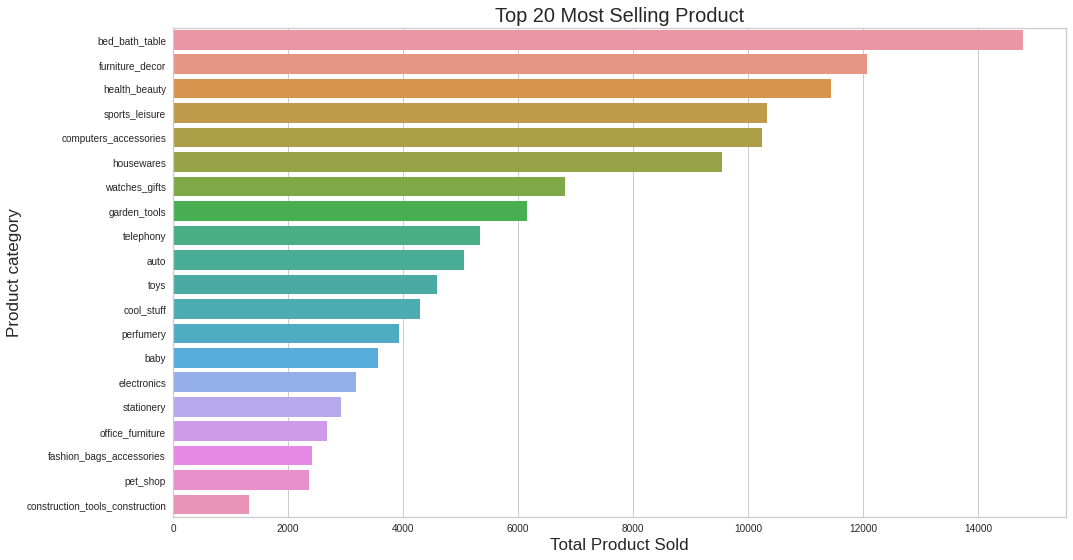

In [235]:
#Produk apa yang paling laris?
top_20_product_best_seller = all_data['order_item_id'].groupby(all_data['product_category_name_english']).sum().sort_values(ascending=False)[:20]
#print(top_20_product_best_seller)

#Kita plot untuk visualisasinya
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_product_best_seller.index,x=top_20_product_best_seller.values)
plt.title('Top 20 Most Selling Product',fontsize=20)
plt.xlabel('Total Product Sold',fontsize=17)
plt.ylabel('Product category',fontsize=17)

Text(0, 0.5, 'City')

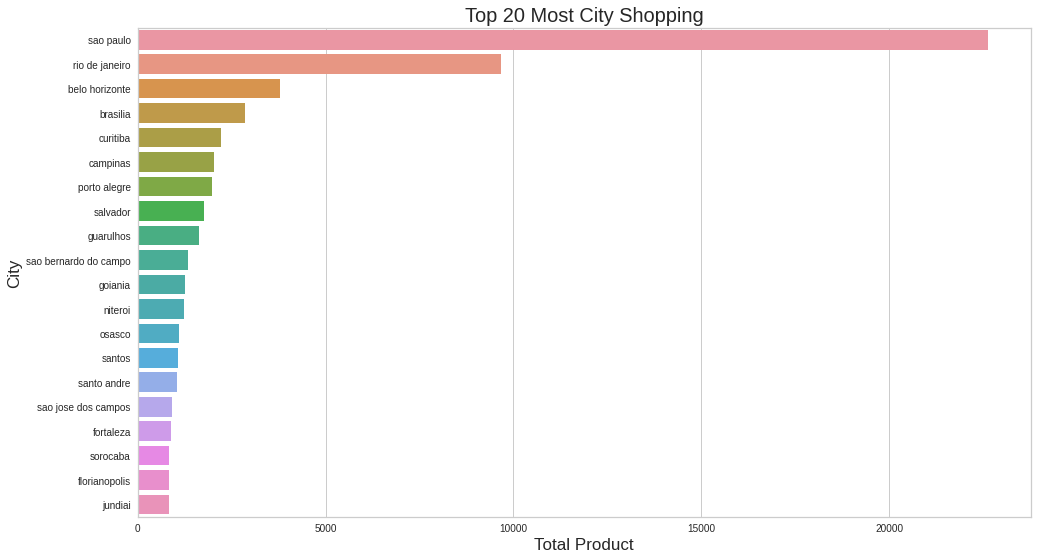

In [236]:
#Kota mana yang paling banyak belanja?
top_20_city_shopping = all_data['order_item_id'].groupby(all_data['customer_city']).sum().sort_values(ascending=False)[:20]
#print(top_20_city_shopping)

#Kita plot untuk visualisasinya
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_city_shopping.index,x=top_20_city_shopping.values)
plt.title('Top 20 Most City Shopping',fontsize=20)
plt.xlabel('Total Product',fontsize=17)
plt.ylabel('City',fontsize=17)

Text(0, 0.5, 'Customer ID')

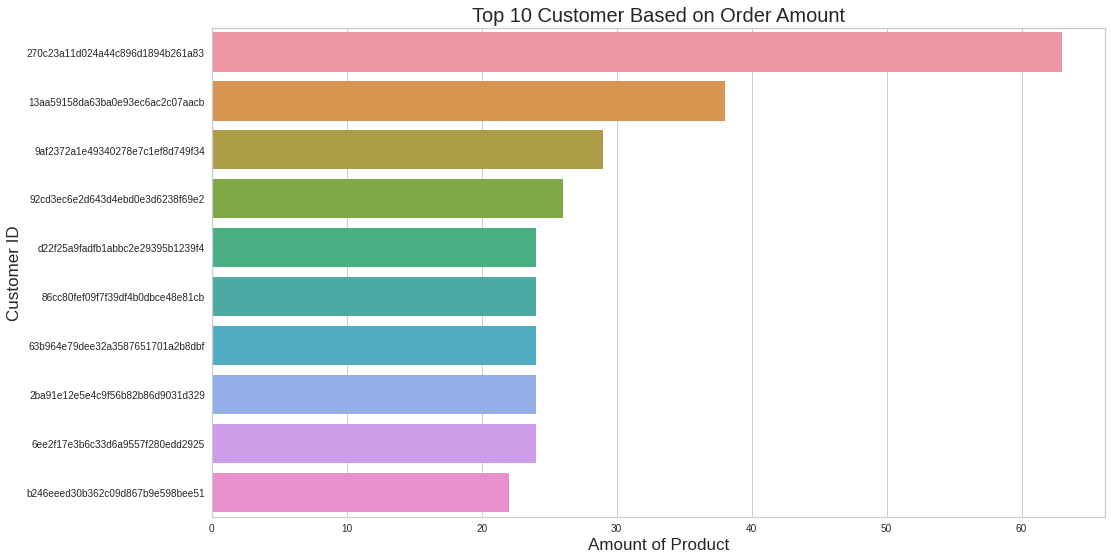

In [237]:
#Siapa customer paling banyak belanja berdasarkan jumlah order?
top_10_customer_shopping = all_data['order_item_id'].groupby(all_data['customer_id']).count().sort_values(ascending=False)[:10]
#print(top_10_customer_shopping)

#Kita plot untuk visualisasinya
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values)
plt.title('Top 10 Customer Based on Order Amount',fontsize=20)
plt.xlabel('Amount of Product',fontsize=17)
plt.ylabel('Customer ID',fontsize=17)

Text(0, 0.5, 'Customer ID')

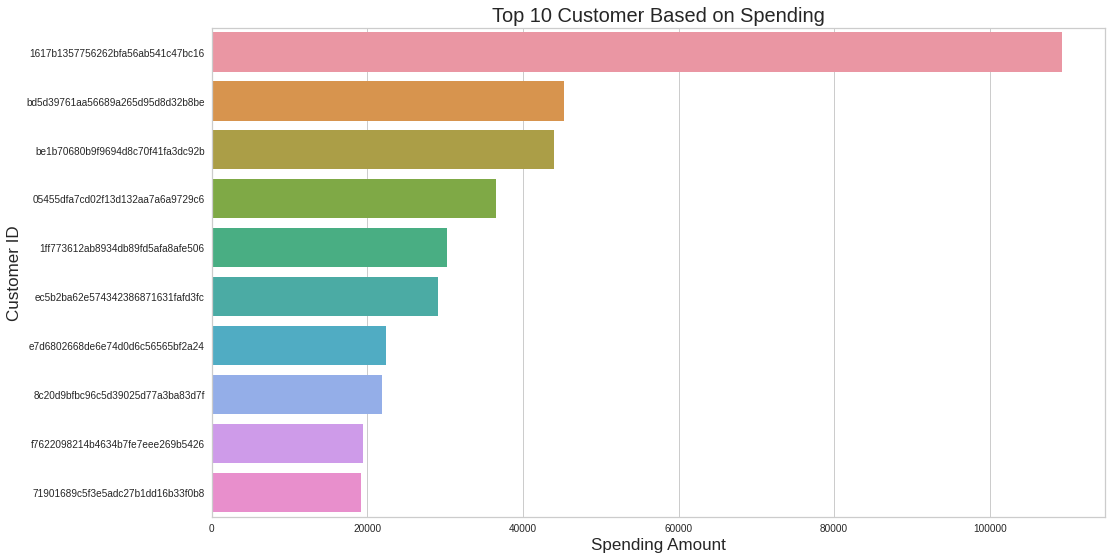

In [238]:
#Siapa customer yang paling banyak pengeluaranya dalam belanja berdasarkan harga?
top_10_customer_shopping = all_data['payment_value'].groupby(all_data['customer_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_customer_shopping)

#Kita plot untuk visualisasinya
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values)
plt.title('Top 10 Customer Based on Spending',fontsize=20)
plt.xlabel('Spending Amount',fontsize=17)
plt.ylabel('Customer ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

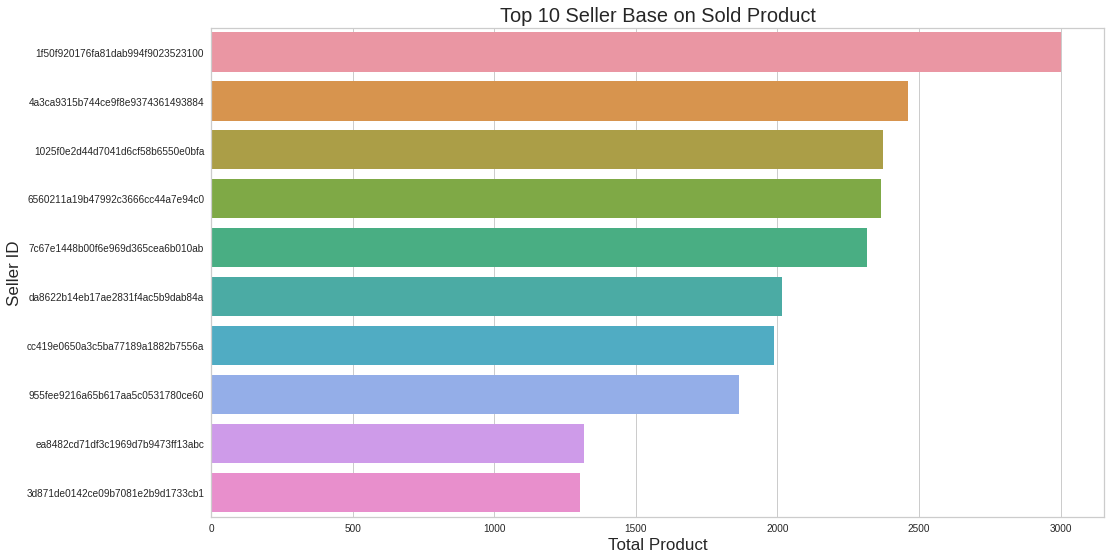

In [239]:
#Seller mana yang paling banyak jual?
top_10_seller_order = all_data['order_item_id'].groupby(all_data['seller_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_seller_order)

#Kita plot untuk visualisasinya
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.values)
plt.title('Top 10 Seller Base on Sold Product',fontsize=20)
plt.xlabel('Total Product',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

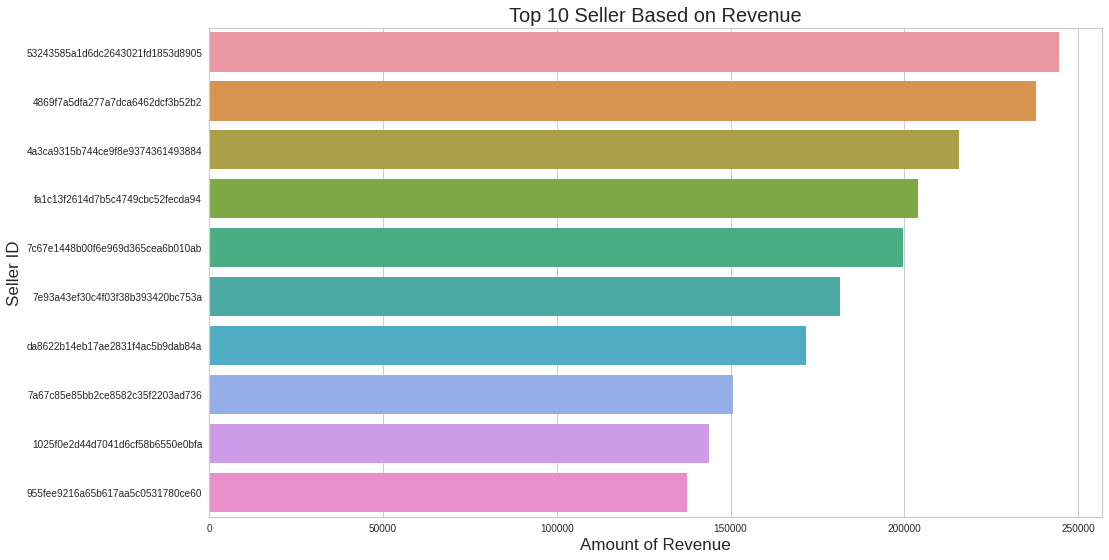

In [240]:
#Seller mana yang paling banyak penghasilan berdasarkan revenue?
top_10_seller_order = all_data['price'].groupby(all_data['seller_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_seller_order)

#Kita plot untuk visualisasinya
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.values)
plt.title('Top 10 Seller Based on Revenue',fontsize=20)
plt.xlabel('Amount of Revenue',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

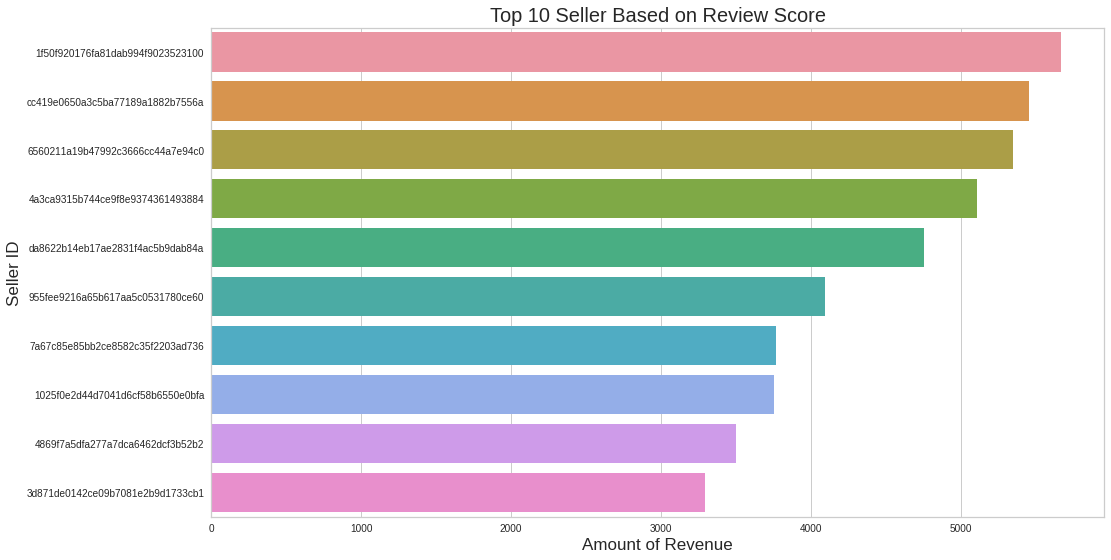

In [241]:
#Seller mana yang paling banyak penghasilan berdasarkan revenue?
top_10_seller_order = all_data[all_data['review_score'] == 5].groupby(all_data['seller_id']).sum().sort_values(by=['review_score'],ascending=False)[:10]
#print(top_10_seller_order)

#Kita plot untuk visualisasinya
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.review_score)
plt.title('Top 10 Seller Based on Review Score',fontsize=20)
plt.xlabel('Amount of Revenue',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

In [242]:
#Sebaran status order customer
round(all_data.order_status.value_counts() / len(all_data),2)

delivered     0.98
shipped       0.01
canceled      0.00
processing    0.00
invoiced      0.00
approved      0.00
Name: order_status, dtype: float64

Text(0, 0.5, 'Time (Day)')

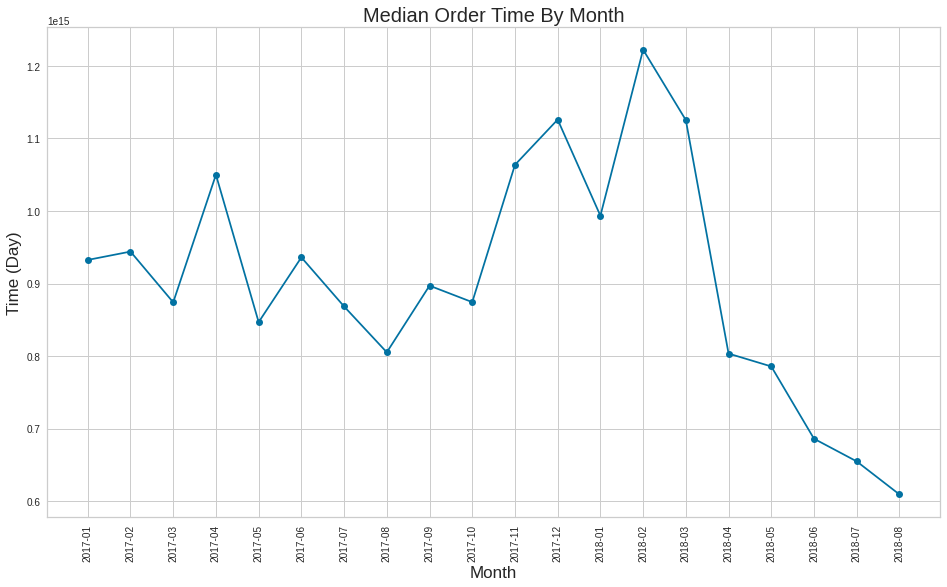

In [243]:
#Berapa median waktu dari order sampai diterima yang dibutuhkan dalam setiap order perbulanya?
order_time_by_month = all_data['order_process_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

#Membuat visualisasinya
fig=plt.figure(figsize=(16,9))
plt.plot(order_time_by_month.index, order_time_by_month.values, marker='o')
plt.title('Median Order Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
#         ['January', 'February', 'March','April', 'Mei', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

Text(0, 0.5, 'Time (Day)')

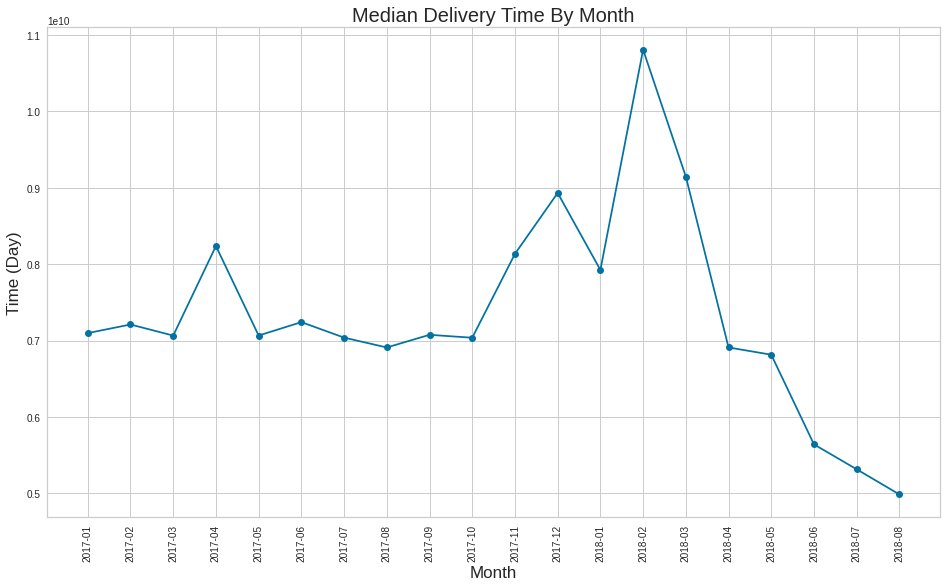

In [244]:
#Berapa median waktu pengiriman yang dibutuhkan dalam setiap order perbulanya?
delivery_time_by_month = all_data['order_delivery_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

#Membuat visualisasinya
fig=plt.figure(figsize=(16,9))
plt.plot(delivery_time_by_month.index, delivery_time_by_month.values / 86400, marker='o')
plt.title('Median Delivery Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
         # ['January', 'February', 'March','April', 'Mei', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

Text(0, 0.5, 'Time (Day)')

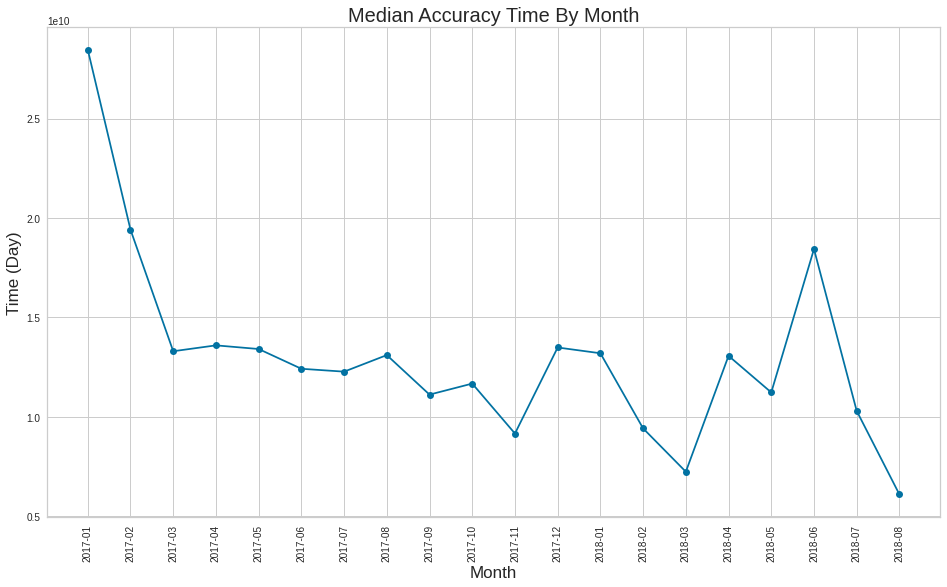

In [245]:
#Berapa median akurasi waktu dari estimasi pengiriman dan samapi customer dalam setiap order perbulanya?
accuracy_time_by_month = all_data['order_accuracy_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

#Membuat visualisasinya
fig=plt.figure(figsize=(16,9))
plt.plot(accuracy_time_by_month.index, accuracy_time_by_month.values / 86400, marker='o')
plt.title('Median Accuracy Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          #['January', 'February', 'March','April', 'Mei', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

Text(0, 0.5, 'Time (Minutes)')

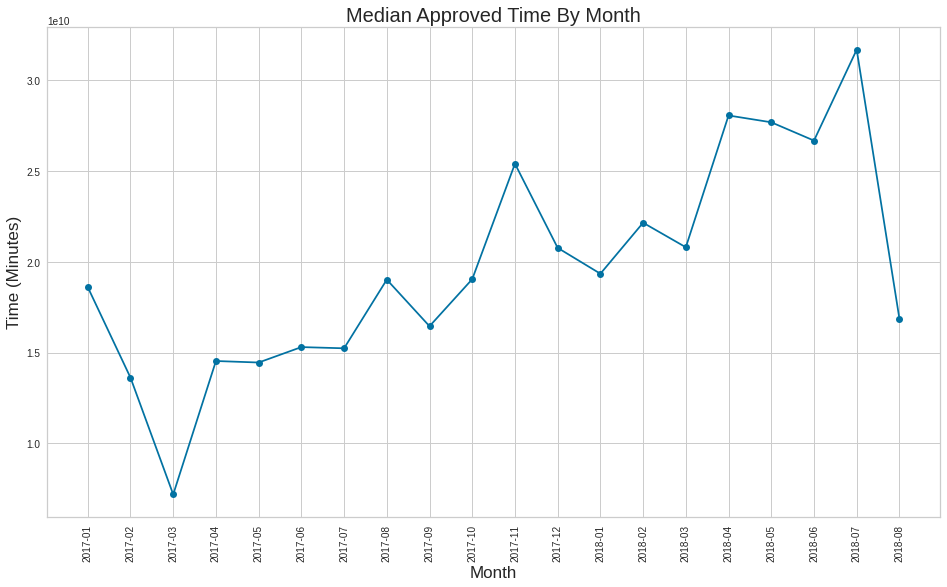

In [246]:
#Berapa median lama waktu sampai diapproved dari waktu order dalam setiap order perbulanya?
approved_time_by_month = all_data['order_approved_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

#Membuat visualisasinya
fig=plt.figure(figsize=(16,9))
plt.plot(approved_time_by_month.index, approved_time_by_month.values / 60, marker='o')
plt.title('Median Approved Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
         # ['January', 'February', 'March','April', 'Mei', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
          rotation=90)
plt.ylabel('Time (Minutes)',fontsize=17)

Text(0, 0.5, 'Product Category')

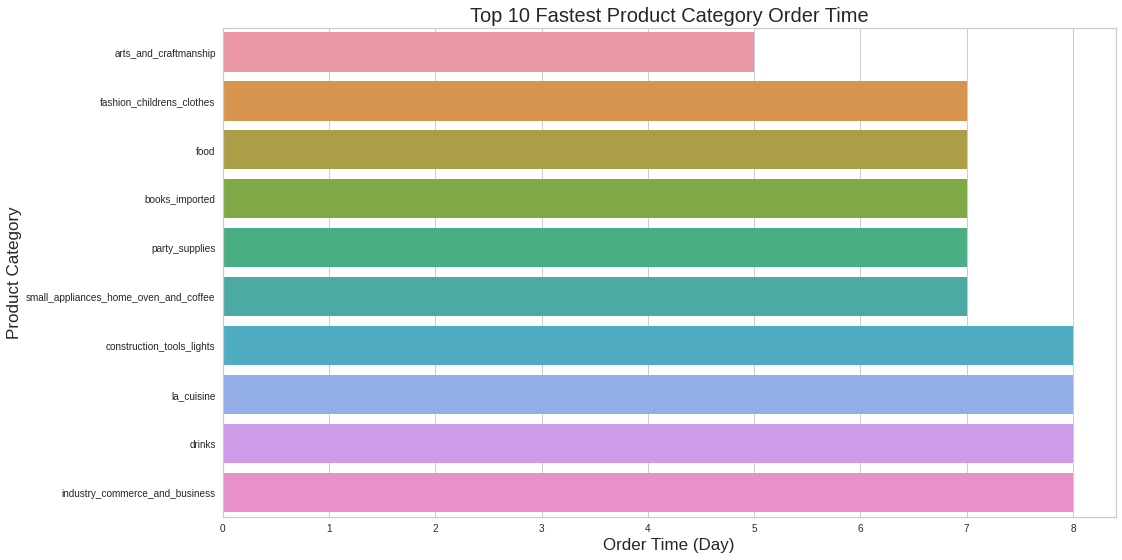

In [247]:
#10 kategori produk dengan waktu tercepat mulai dari order sampai diterima customer
order_time_by_category = pd.DataFrame(all_data['order_process_time'].groupby(all_data['product_category_name_english']).median(numeric_only=False).sort_values(ascending=True)[:10])

#Visualiasi
fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_time_by_category.index, x=order_time_by_category['order_process_time'].dt.days)
plt.title('Top 10 Fastest Product Category Order Time',fontsize=20)
plt.xlabel('Order Time (Day)',fontsize=17)
plt.ylabel('Product Category',fontsize=17)

Text(0, 0.5, 'Product Category')

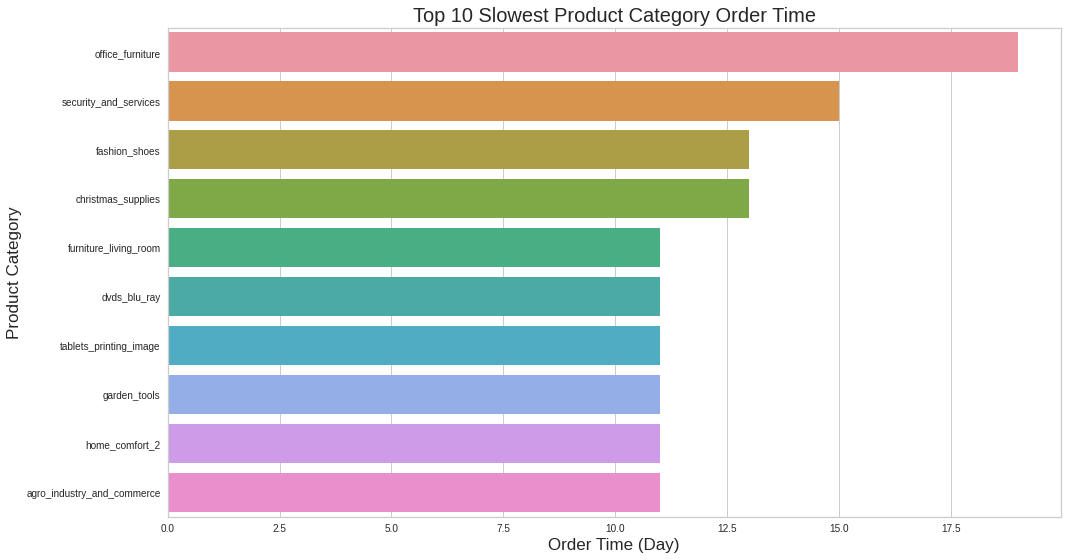

In [248]:
#10 kategori produk dengan waktu paling lama mulai dari order sampai diterima customer
order_time_by_category = pd.DataFrame(all_data['order_process_time'].groupby(all_data['product_category_name_english']).median(numeric_only=False).sort_values(ascending=False)[:10])

#Visualiasi
fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_time_by_category.index, x=order_time_by_category['order_process_time'].dt.days)
plt.title('Top 10 Slowest Product Category Order Time',fontsize=20)
plt.xlabel('Order Time (Day)',fontsize=17)
plt.ylabel('Product Category',fontsize=17)

Text(0, 0.5, 'Amount Order')

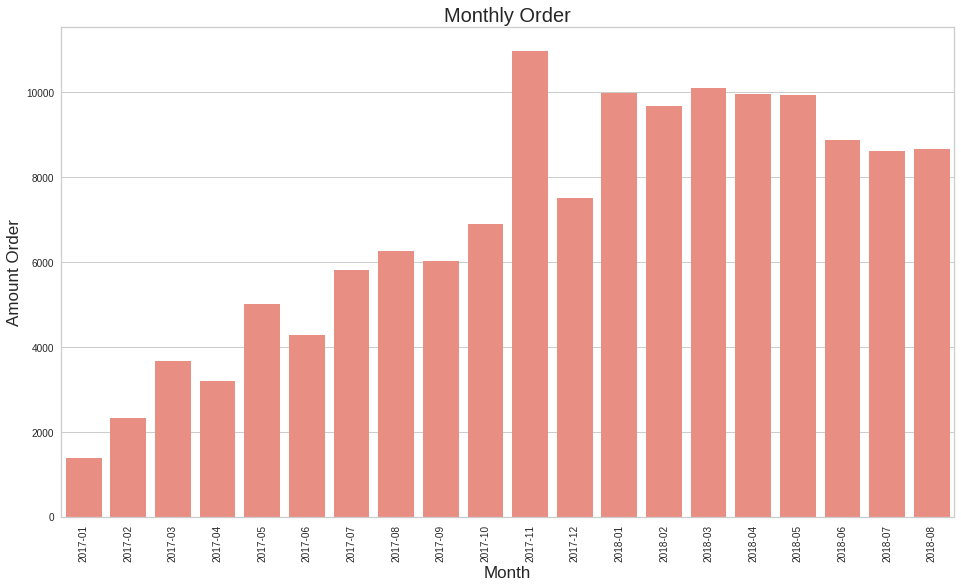

In [249]:
#Berapakah Order setiap bulanya?
order_count_by_month = all_data['order_item_id'].groupby(all_data['Month_order']).sum()

#Visualisasi
fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_count_by_month.values, x=order_count_by_month.index, color="Salmon")
plt.title('Monthly Order',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Amount Order',fontsize=17)

Text(0, 0.5, 'Amount Revenue')

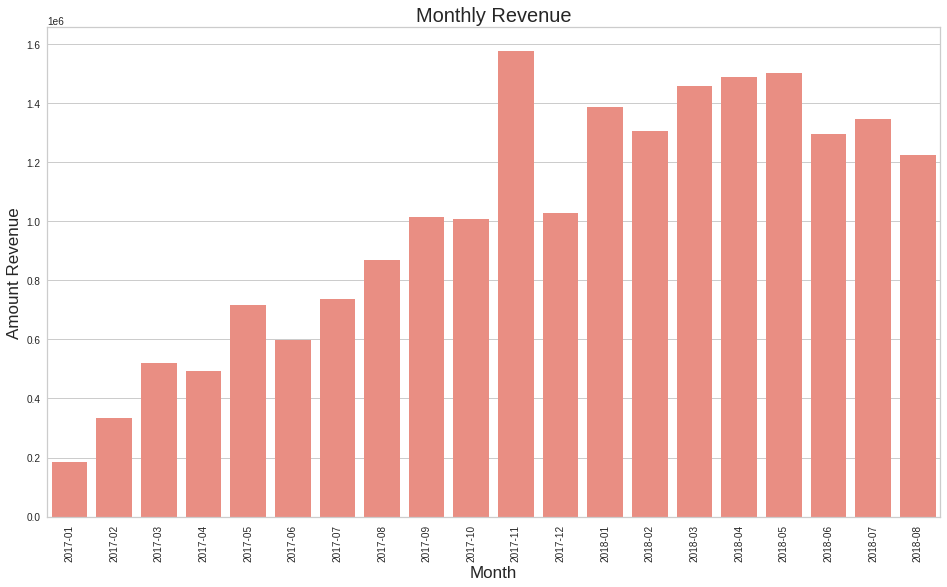

In [250]:
#Berapakah Revenue setiap bulanya?
revenue_count_by_month = all_data['payment_value'].groupby(all_data['Month_order']).sum()

#Visualisasi
fig=plt.figure(figsize=(16,9))
sns.barplot(y=revenue_count_by_month.values, x=revenue_count_by_month.index, color="Salmon")
plt.title('Monthly Revenue',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Amount Revenue',fontsize=17)

Text(0, 0.5, 'Amount of User')

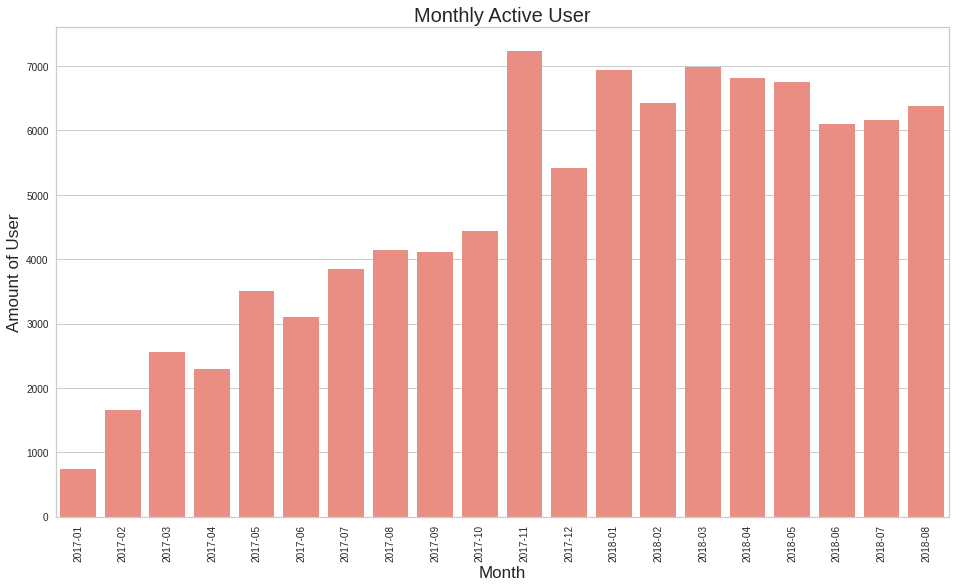

In [251]:
#Berapaka customer aktif setiap bulanya?
customer_active_by_month = all_data.groupby('Month_order')['customer_unique_id'].nunique().reset_index()

#Visualisasi
fig=plt.figure(figsize=(16,9))
sns.barplot(y=customer_active_by_month['customer_unique_id'], x=customer_active_by_month['Month_order'], color="Salmon")
plt.title('Monthly Active User',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Amount of User',fontsize=17)

# **3. Modelling** 

Pada tahapan ini akan dilakukan modeling menggunakan algoritma clustering yaitu K-Means berdasarkan RFM (Recency, Frequency, dan Monetary) analysis untuk customer segmentation.

## **3.1 RFM Analysis** 

RFM analysis merupakan sebuah metode yang digunakan untuk melihat pola pada pelanggan berdasarkan gaya kebiasaan mereka dalam membeli:

1. Recency = Kapan waktu terakhir kali si pelanggan melakukan transaksi
 
2. Frequency = Sebarapa sering si pelanggan untuk melakukan pembelian

3. Monetary = Sebarapa banyak pelanggan menghabiskan uang


In [252]:
#melihat tanggal awal dan terakhir pembelian 
print('Min : {}, Max : {}'.format(min(all_data.order_purchase_timestamp), max(all_data.order_purchase_timestamp)))

Min : 2017-01-05 11:56:06, Max : 2018-08-29 15:00:37


In [253]:
#Menghitung RFM
import datetime as dt
pin_date = max(all_data.order_purchase_timestamp) + dt.timedelta(1)

#Membuat dataframe RFM
rfm = all_data.groupby('customer_unique_id').agg({
    'order_purchase_timestamp' : lambda x: (pin_date - x.max()).days,
    'order_item_id' : 'count', 
    'payment_value' : 'sum'})

#Merubah nama kolom
rfm.rename(columns = {'order_purchase_timestamp' : 'Recency', 
                      'order_item_id' : 'Frequency', 
                      'payment_value' : 'Monetary'}, inplace = True)

rfm.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19
0000f46a3911fa3c0805444483337064,537,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
0004aac84e0df4da2b147fca70cf8255,288,1,196.89


## **3.2 Handling Outliers**

Pada tahapan ini akan dilakukan pemberishan data dari input yang mungkin salah atau anomali dari data yang kita miliki.

In [254]:
#Kita akan menggunakan Inter Quartile Range untuk menangani ouliers
#Menentukan Limit
def limit(i):
    Q1 = rfm[i].quantile(0.5)
    Q3 = rfm[i].quantile(0.95)
    IQR = Q3 - Q1
    
    #menentukan upper limit biasa dan upper limit ekstim
    lower_limit = rfm[i].quantile(0.5) - (IQR * 1.5)
    lower_limit_extreme = rfm[i].quantile(0.5) - (IQR * 3)
    upper_limit = rfm[i].quantile(0.95) + (IQR * 1.5)
    upper_limit_extreme = rfm[i].quantile(0.5) + (IQR * 3)
    print('Lower Limit:', lower_limit)
    print('Lower Limit Extreme:', lower_limit_extreme)
    print('Upper Limit:', upper_limit)
    print('Upper Limit Extreme:', upper_limit_extreme)

#Mengitung persen outliers dari data    
def percent_outliers(i):
    Q1 = rfm[i].quantile(0.5)
    Q3 = rfm[i].quantile(0.95)
    IQR = Q3 - Q1
    
    #menentukan upper limit biasa dan upper limit ekstim
    lower_limit = rfm[i].quantile(0.5) - (IQR * 1.5)
    lower_limit_extreme = rfm[i].quantile(0.5) - (IQR * 3)
    upper_limit = rfm[i].quantile(0.95) + (IQR * 1.5)
    upper_limit_extreme = rfm[i].quantile(0.95) + (IQR * 3)
    #melihat persenan outliers terhadap total data
    print('Lower Limit: {} %'.format(rfm[(rfm[i] >= lower_limit)].shape[0]/ rfm.shape[0]*100))
    print('Lower Limit Extereme: {} %'.format(rfm[(rfm[i] >= lower_limit_extreme)].shape[0]/rfm.shape[0]*100))
    print('Upper Limit: {} %'.format(rfm[(rfm[i] >= upper_limit)].shape[0]/ rfm.shape[0]*100))
    print('Upper Limit Extereme: {} %'.format(rfm[(rfm[i] >= upper_limit_extreme)].shape[0]/rfm.shape[0]*100))

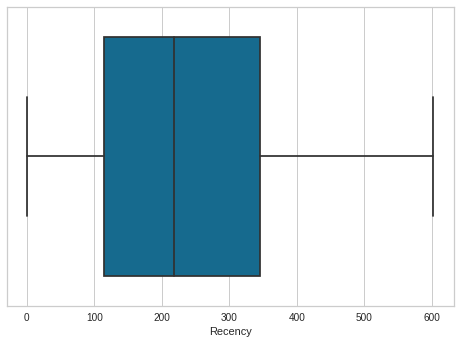

In [255]:
#Melihat outliers pada kolom Recency
sns.boxplot(x=rfm["Recency"])

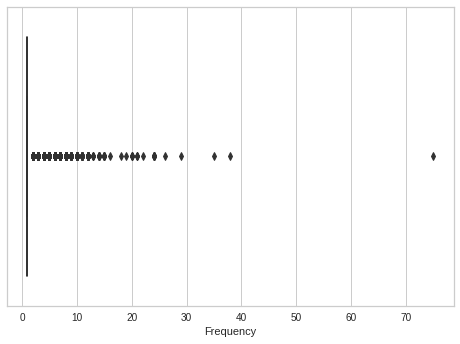

In [256]:
#Melihat ouliers pada kolom Frequency
sns.boxplot(x=rfm["Frequency"])

Kolom Frequency tidak dilakukan penghilangan outliers karena outliers disisni memang kemungkinan pelanggan melkaukan transaksi yang sangat banyak karena data ini diambil dari 2017-2018

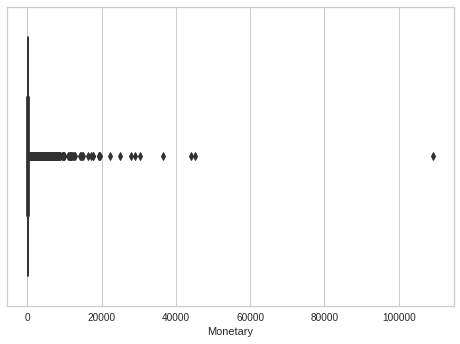

In [257]:
#Melihat ouliers pada kolom Monetary
sns.boxplot(x=rfm["Monetary"])

In [258]:
print(limit('Monetary'))
print('-'*50)
print(percent_outliers('Monetary'))

Lower Limit: -719.16
Lower Limit Extreme: -1551.4499999999998
Upper Limit: 1500.28
Upper Limit Extreme: 1777.71
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 1.2549312293421473 %
Upper Limit Extereme: 0.5363045100757011 %
None


In [259]:
#Menghilangkan outliers pada kolom Monetary yang lebih dari 1500 karena diluar dari 95% batas maksimal atas persebaran data
outliers1_drop = rfm[(rfm['Monetary'] > 1500)].index
rfm.drop(outliers1_drop, inplace=True)

## **3.3 RFM Percentile** 

Pada tahapan ini akan dibuat group pelanggan/customer berdarkan Recency, Frequency, dan Monetary dengan membaginya menjadi 3**** group di setiapnya.

In [260]:
#Membuat group customer berdasarkan Recency, Frequency, dan Monetary
#Karena Recency jika semakin sedikit harinya semakin bagus, maka akan membuat urutanya secara terbalik
r_labels = range(3, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 3, labels = r_labels).astype('int')

#Karena Frequency sangat banyak pada nilai 1, maka tidak bisa menggunakan qcut, 
#karena nilainya akan condong ke yang paling banyak
f_groups = pd.qcut(rfm.Frequency.rank(method='first'), 3).astype('str')
#rfm['F'] = np.where((rfm['Frequency'] != 1) & (rfm['Frequency'] != 2), 3, rfm.Frequency)

m_labels = range(1, 4)
m_groups = pd.qcut(rfm.Monetary, q = 3, labels = m_labels).astype('int')

In [261]:
#Membuat kolom berdasarkan group yang telah dibuat
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

In [262]:
rfm['F'].value_counts()

(61741.667, 92612.0]      30871
(0.999, 30871.333]        30871
(30871.333, 61741.667]    30870
Name: F, dtype: int64

In [263]:
#Merubah input kolom F menjadi categorical
rfm['F'] = rfm['F'].replace({'(0.999, 30871.333]' : 1,
                             '(30871.333, 61741.667]' : 2,
                             '(61741.667, 92612.0]' : 3}).astype('int')

In [264]:
#Menggabungkan ketiga kolom tersebut
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,3,1,2,3.01.02.0,6
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,3.01.01.0,5
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,1.01.02.0,4
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,1,1,1,1.01.01.0,3
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,2.01.03.0,6


In [265]:
#Membuat label berdasarkan RFM_Score
score_labels = ['Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(rfm.RFM_Score, q=3, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,3,1,2,3.01.02.0,6,Silver
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,3.01.01.0,5,Bronze
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,1.01.02.0,4,Bronze
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,1,1,1,1.01.01.0,3,Bronze
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,2.01.03.0,6,Silver


##  **3.4 Handling Skewness & Scaling**

Untuk data  yang akan masuk ke dalam algortimna K-Means, diusahakan distribusinya normal karena akan memudahkan pembentukan clusternya kemudian jangan lupa untuk menyamakan skala dari setiap kolom yang ada karena akan diukur berdasarkan jarak antar tiap input.

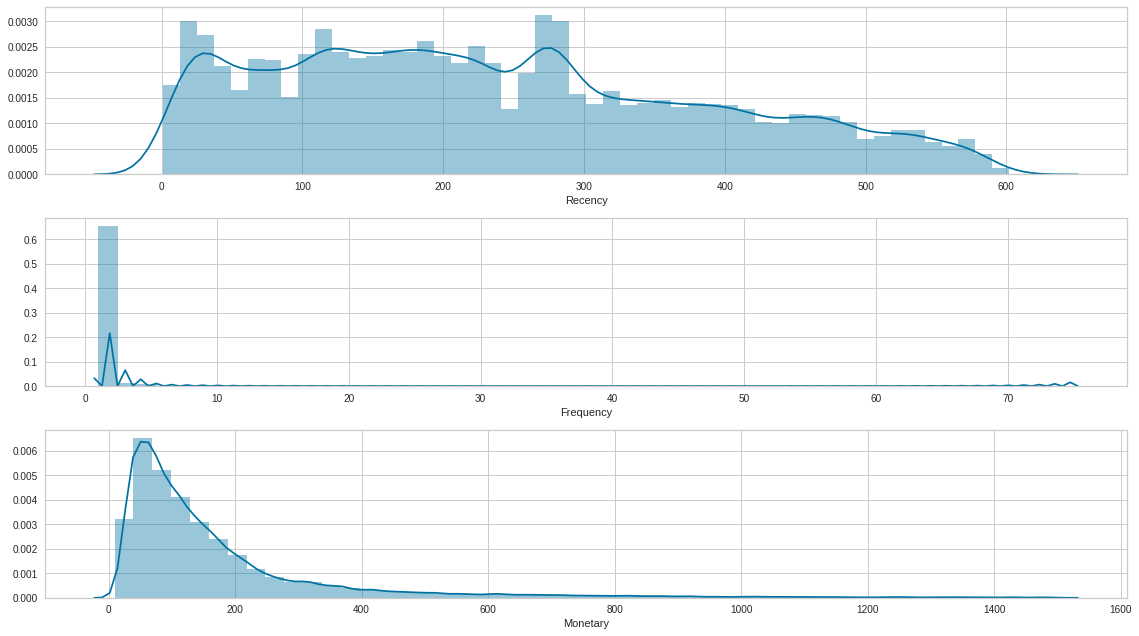

In [266]:
#Visualisasi nilai RFM
fig, ax = plt.subplots(figsize=(16, 9))
plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'], kde_kws={'bw': 0.1}, label='Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm.Monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

In [267]:
#Membuat distribusi data menjadi normal
from scipy import stats

rfm_log = rfm[['Recency', 'Monetary']].apply(np.log, axis = 1).round(3)
rfm_log['Frequency'] = stats.boxcox(rfm['Frequency'])[0]
rfm_log.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,4.718,4.955,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,4.745,3.303,0.0
0000f46a3911fa3c0805444483337064,6.286,4.457,0.0
0000f6ccb0745a6a4b88665a16c9f078,5.771,3.776,0.0
0004aac84e0df4da2b147fca70cf8255,5.663,5.283,0.0


In [268]:
#Membuat semua data dala ukuran yang sama dengan cara scaling
scaler = StandardScaler()
minmax = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [269]:
#Membuat dataframe baru setelah di-scaling
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)
rfm_scaled.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.456069,0.220580,-0.408549
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.427655,-1.712288,-0.408549
0000f46a3911fa3c0805444483337064,1.194001,-0.362089,-0.408549
0000f6ccb0745a6a4b88665a16c9f078,0.652046,-1.158870,-0.408549
0004aac84e0df4da2b147fca70cf8255,0.538393,0.604345,-0.408549


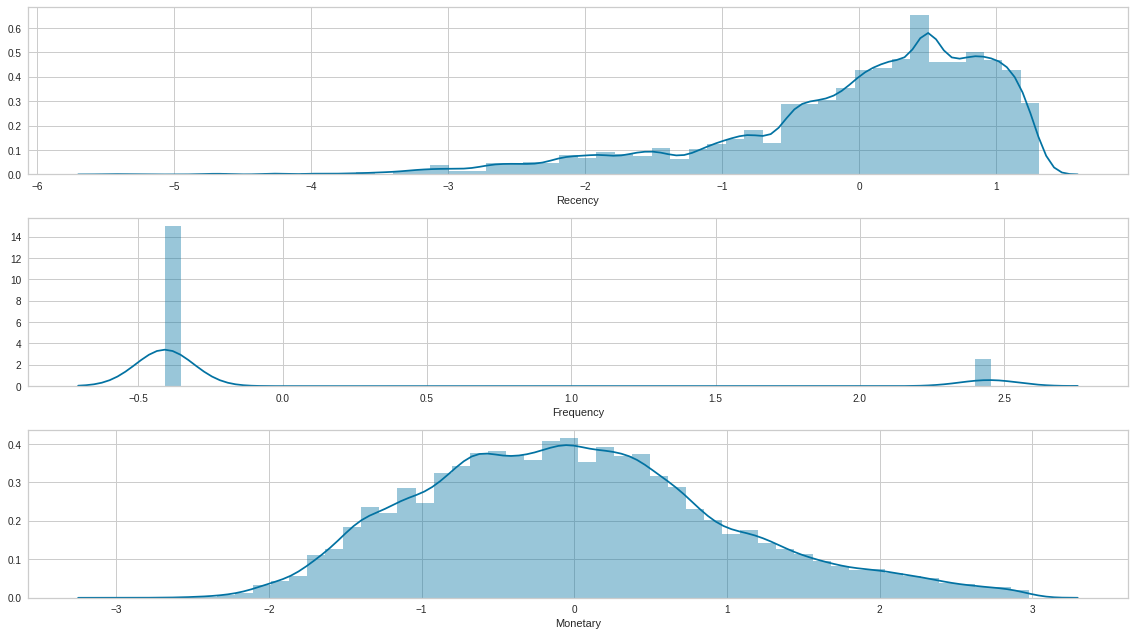

In [270]:
#Visualisasi kembali RFM setalah log transformasi dan scaling
fig, ax = plt.subplots(figsize=(16, 9))
plt.subplot(3, 1, 1); sns.distplot(rfm_scaled.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_scaled.Frequency, kde_kws={'bw': 0.1}, label='Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_scaled.Monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

## **3.5 K-Means Clustering**

Di sini akan dilakukan clustering dengan menggunakan algoritma K-Means untuk mendapatkan cluster yang optimal dari data RFM

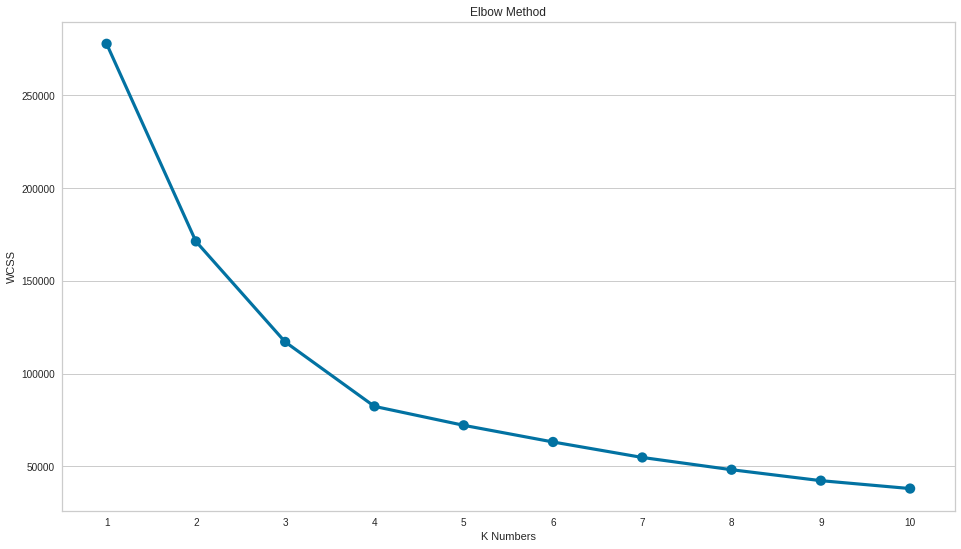

In [271]:
#Mencari titik optimal cluster dengan ELbow Method
wcss = {}

for i in range(1, 11):
    kmeans = KMeans(n_clusters= i, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_scaled)
    wcss[i] = kmeans.inertia_
    
#Visualisasi Elbow Method
fig, ax = plt.subplots(figsize=(16, 9))
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.title('Elbow Method')
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

In [272]:
#Memilih n_clusters = 4 sesuai dengan elbow method
clus = KMeans(n_clusters= 4, n_init=10, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [273]:
#Mausukka hasil cluster ke data rfm awal
rfm['K_Cluster'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,3,1,2,3.01.02.0,6,Silver,2
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,3.01.01.0,5,Bronze,1
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,1.01.02.0,4,Bronze,1
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,1,1,1,1.01.01.0,3,Bronze,1
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,2.01.03.0,6,Silver,2


## **3.6 Evaluation** 

Setelah kita membuat model dengan menggunakan KMeans, sekarang kita akan mengevaluasi model tersebut apakah cluster yang dibuatnya benar-benar berbeda dari setiap cluster dengan menggunakan Silhouuette Analysis. Semakin dia mendekati angka 1 maka perbedaan dia dengan clsuter yang lain semakin jelas, jika nilainya mendekati 0, maka dia semakin menyerupai cluster didekatnya dan jika -1 maka dia salah membuat cluster.

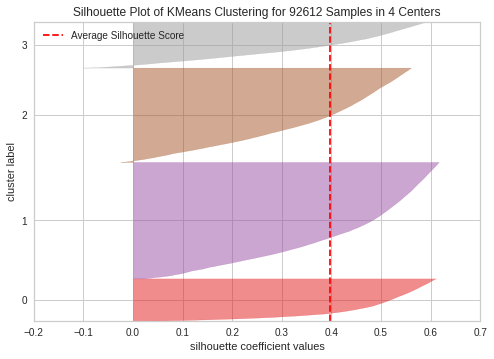

In [274]:
#Visualisasi Silhouette Analysis
visualizer = SilhouetteVisualizer(clus)

visualizer.fit(rfm_scaled) 
visualizer.poof() 

## **3.5 Visualization**

Kita akan memvisualisasi untuk memudahkan meilhat cluster yang kita buat  dengan cluster dari algortima KMeans. Kita akan menggunakan 'Snake Plot' dalam dunia marketing untuk melihat kategori apa saja yang masuk kedalam sebuah cluster.

In [275]:
#Masukkan semua ke dalam data yang sudah di scaling 
rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm.RFM_Level
rfm_scaled.reset_index(inplace = True)
rfm_scaled.head()

,customer_unique_id,Recency,Monetary,Frequency,K_Cluster,RFM_Level
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.456069,0.220580,-0.408549,2,Silver
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.427655,-1.712288,-0.408549,1,Bronze
2,0000f46a3911fa3c0805444483337064,1.194001,-0.362089,-0.408549,1,Bronze
3,0000f6ccb0745a6a4b88665a16c9f078,0.652046,-1.158870,-0.408549,1,Bronze
4,0004aac84e0df4da2b147fca70cf8255,0.538393,0.604345,-0.408549,2,Silver


In [276]:
#melting data frame yang telah dibuat
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['customer_unique_id', 'RFM_Level', 'K_Cluster'], 
                     var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,customer_unique_id,RFM_Level,K_Cluster,Metrics,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,Silver,2,Recency,-0.456069
1,0000b849f77a49e4a4ce2b2a4ca5be3f,Bronze,1,Recency,-0.427655
2,0000f46a3911fa3c0805444483337064,Bronze,1,Recency,1.194001
3,0000f6ccb0745a6a4b88665a16c9f078,Bronze,1,Recency,0.652046
4,0004aac84e0df4da2b147fca70cf8255,Silver,2,Recency,0.538393


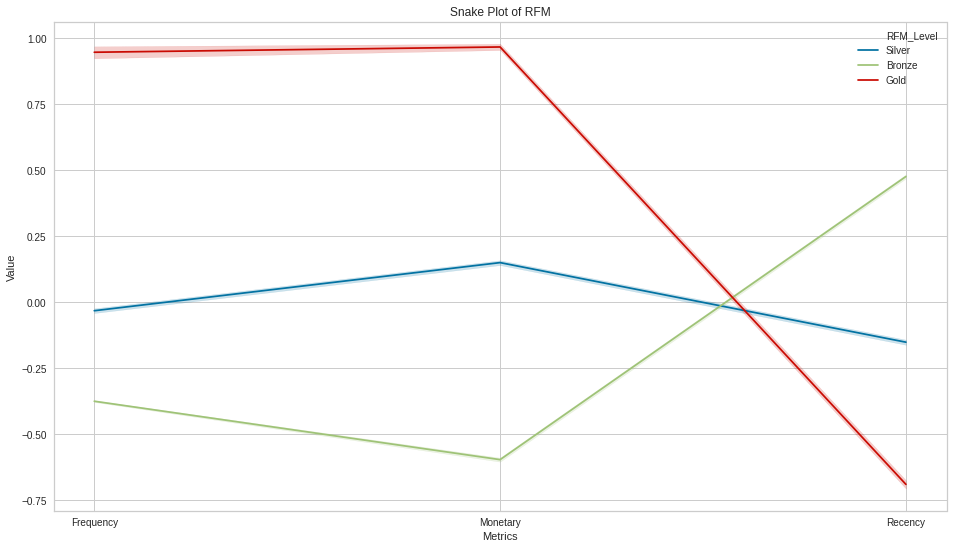

In [280]:
#Visualisasi snake plot
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

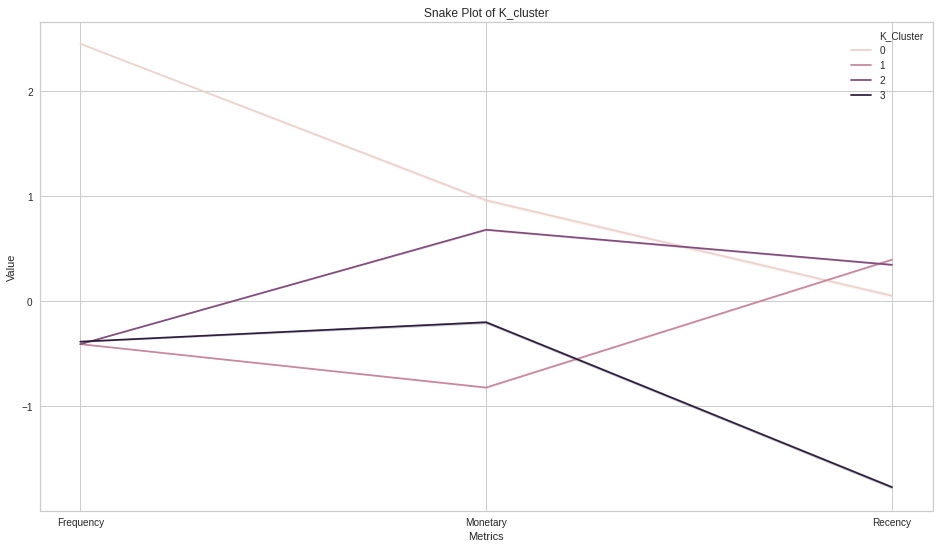

In [278]:
#Visualisasi snake plot dengan K-Means
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of K_cluster')
plt.legend(loc = 'upper right')

Seperti yang kita lihat pada kedua grafik di atas, kita dapat simpulkan berdasarkan cluster:
1. Bronze (1 & 0): Frequencynya tidak terlalu tinggi dibandingkan nominal transaksinya namun waktu terakhir dia transaksi cepat
2. Silver (2): Frequencya cukup tinggi dan nominal transaksinya cukup tinggi namun waktu terakhir dia transaksi cukup lama
3. Gold (3):  Frequency dia untuk belanja itu tinggi dan nominal yang dihabiskannya juga banyak, namun waktu terakhir transaksi lama

Text(0, 0.5, 'Amount of Customer')

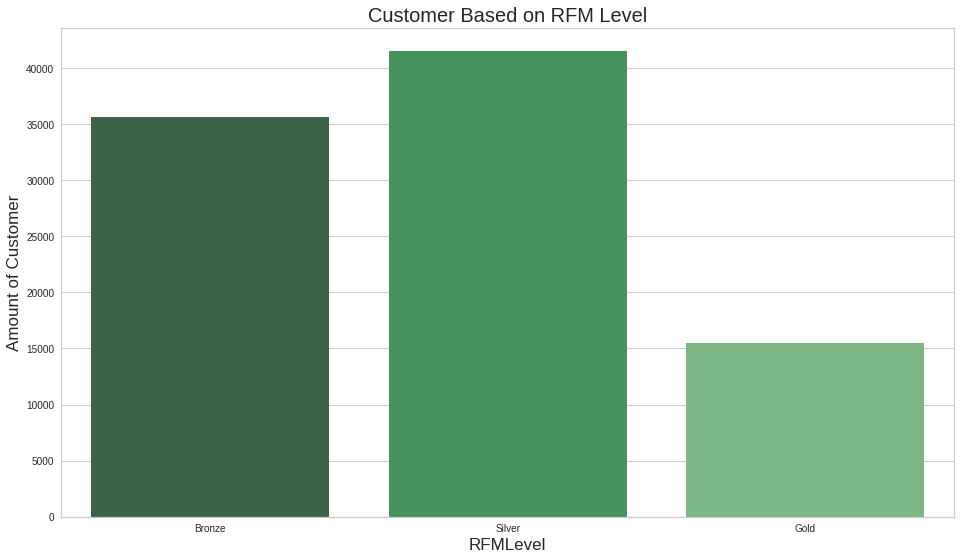

In [279]:
#Berapaka jumlah customer berdasarkan kategorinya?
rfm_cus_level = rfm_scaled.groupby('RFM_Level')['customer_unique_id'].nunique().reset_index()

#Visualisasi
fig=plt.figure(figsize=(16,9))
sns.barplot(y=rfm_cus_level['customer_unique_id'], x=rfm_cus_level['RFM_Level'], palette="Greens_d")
plt.title('Customer Based on RFM Level',fontsize=20)
plt.xlabel('RFMLevel',fontsize=17)
plt.ylabel('Amount of Customer',fontsize=17)

# **4. KESIMPULAN**

Seoerti tujuan pada project kali ini yaitu memudahkan bagian marketing untuk melakukan campaign atau promosi berdasarkan segmentasi pelanggan, berikut adalah kesimpulanya:

1. Bronze : Pelanggan yang yang tidak terlalu sering melakukan pembelian dan nominal transaksinya rendah namun waktu terakhir dia transaksi cepat. Pelanggan tipe ini ada sebanyak 36000.
    - Action: Bisa dicoba dengan memberikan diskon atau penawaran dengan nominal yang terjangkau agar convertion ratenya meningkat karena jumlah pelanggan kategori Bronze cukup banyak
2. Silver : Pelanggan yang cukup sering melakukan pembelian dan nominal transaksinya cukup tinggi namun waktu terakhir dia transaksi cukup lama. Pelanggan tipe ini ada sebanyak 42000.
    - Action: DIberikan kombinasi antara diskon dan campaign setelah transaksi untuk meningkatkan pembelian dengan menggunakan personilized email yang dapat memberikan sentuhan personal.
3. Gold : Pelanggan yang sering belanja dan nominal transaksinya juga banyak, namun waktu terakhir transaksi lama. Pelanggan tipe ini ada sebanyak 15000.
    - Action: Lebih sering diberikan campaign etelah melakukan transaksi agar kembali melakukan pembelian. Bisa juga dengan memebrikan reward karena mereka lebih serng melakukan transaksi dan nominalnya tinggi.